In [1]:
import os
import numpy as np
from scipy.signal import butter, iirnotch, lfilter
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import neurokit2 as nk
import pandas as pd
from ecgdetectors import Detectors
import pyhrv.frequency_domain as fd
import pyhrv.time_domain as td
import pyhrv
import hrvanalysis

In [2]:
# import ipynb
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# import os
# import pickle
# from scipy import signal
# # import neurokit2 as nk
# import random
# # %matplotlib inline 
# import pyhrv
# import ipynb

In [3]:
# Dataset reading
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [4]:

# fs = 700 # sampling frequency
# y = []
# # data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
# data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
# # data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"

# subject = 'S6'
# obj_data = {}

# # Accessing class attributes and method through objects
# obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

# chest_data_dict = obj_data[subject].get_chest_data()
# chest_dict_length = {key: len(value) for key, value in chest_data_dict.items()}

#         # Get labels
# labels = obj_data[subject].get_labels()
# baseline = np.asarray([idx for idx,val in enumerate(labels) if val == 1])

# ecg_base=chest_data_dict['ECG'][baseline,0] # Select the EDA data
# resp_base=chest_data_dict['Resp'][baseline,0] # Select the EDA data

In [125]:
# filtering
def filter_ecgsignal(ecg, fs):
    ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
    filtered_ecg = ecg_td['filtered']

    # t=np.arange(0,ecg.size*(1/fs),(1/fs))
    # t=t[:ecg.size]

    # plt.figure(figsize=(12,4))
    # plt.plot(t,ecg,label="raw ECG")
    # plt.plot(t,filtered_ecg, label="filtered ECG")
    # plt.xlabel('$Time (s)$') 
    # plt.ylabel('$ECG$') 
    # plt.legend(loc='upper left')

    return filtered_ecg

In [126]:
# detect R-peaks
def detect_rpeaks(fs, ecg):
    ecg_td = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
    rpeaks = ecg_td['rpeaks']

    # plt.figure(figsize=(12,4))
    # plt.plot(filtered_ecg,label="ECG")
    # plt.plot(rpeaks,filtered_ecg[rpeaks], 'ro', label="R-peaks")
    # plt.xlabel('$Samples$') 
    # plt.ylabel('$ECG$') 
    # plt.legend(loc='upper left')
    return rpeaks

# **Feature extraction**

In [1]:
from hrv import HRV   # to import the module

# Feature extraction
def get_features(filtered_ecg, r_peaks_pan, fs, df, index):
    features = []

    # Time Domain Features
    hrv_class = HRV(fs)
    
    #Heart-rate feature extraction in BPM(HR)

    HR = hrv_class.HR(r_peaks_pan)
    features.append(np.mean(HR))
    features.append(np.min(HR))
    features.append(np.max(HR))
    features.append(np.std(HR))

    #Standard deviation of NN intervals(SDNN)
    features.append(hrv_class.SDNN(r_peaks_pan, normalise=True))

    #Standard deviation of the average of NN intervals(SDNN)
    features.append(hrv_class.SDANN(r_peaks_pan, normalise=True))

    #Root mean square of succesive differences(RMSSD)
    features.append(hrv_class.RMSSD(r_peaks_pan, normalise= True))

    # Standard deviation of succesive differences(SDSD)
    features.append(hrv_class.SDSD(r_peaks_pan))

    #The proportion of NN50 divided by total number of NNs(pNN50)
    features.append(hrv_class.pNN50(r_peaks_pan))

    #The proportion of NN20 divided by total number of NNs(pNN20)
    features.append(hrv_class.pNN20(r_peaks_pan))

    #Geometrical features('triangular_index', 'tinn')
    features.extend(hrvanalysis.extract_features.get_geometrical_features(r_peaks_pan))

    #Non-linear features ('sd1', 'sd2', 'ratio_sd2_sd1')
    features.extend(hrvanalysis.extract_features.get_poincare_plot_features(r_peaks_pan))

    # Frequency domain features
    rpeaks = r_peaks_pan / fs # R-peaks in sec
    ecg_fft = fd.frequency_domain(rpeaks = rpeaks, show = False) # get the frequency domain features of the HRV

    plt.close(ecg_fft["ar_plot"])
    plt.close(ecg_fft["lomb_plot"])
    plt.close(ecg_fft["fft_plot"])
    
    features.extend(ecg_fft['fft_abs'])
    features.append(ecg_fft['fft_total'])

    features.append(ecg_fft['fft_ratio'])
    features.extend(ecg_fft['fft_peak'])
    features.extend(ecg_fft['fft_norm'])

    ecg_rate = nk.ecg_rate(r_peaks_pan, sampling_rate=fs, desired_length=len(filtered_ecg))
    edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="charlton2016")
    resp_peaks, _ = signal.find_peaks(edr)

    rsp_rate = nk.signal_rate(peaks=resp_peaks, sampling_rate = 700)

    features.extend([max(rsp_rate), min(rsp_rate), np.mean(rsp_rate), np.std(rsp_rate)])

    df.loc[index] = features
    return df

In [1]:
# get features from a signal and adds it to the dataframe
def get_ecgfeatures(ecg, fs, df, index):
    ecg = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
    rpeaks = ecg['rpeaks']
    filtered_ecg = ecg['filtered']
    df_features = get_features(filtered_ecg, rpeaks, fs, df, index)
    return df_features

In [31]:
# ecg = ecg_base[10000: 10000 + 100 * 700]

[72.91666667 71.42857143 69.19275124 63.25301205 65.5226209  63.92694064
 65.31881804 67.30769231 67.63285024 67.52411576 64.81481481 61.94690265
 64.22018349 66.66666667 67.96116505 66.14173228 64.91499227 63.34841629
 65.11627907 68.0713128  68.18181818 66.87898089 67.41573034 66.03773585
 63.25301205 61.13537118 64.51612903 71.55025554 73.81370826 77.77777778
 78.35820896 79.69639469 75.94936709 75.53956835 70.70707071 68.73977087
 68.40390879 70.46979866 69.53642384 67.63285024 66.77265501 69.53642384
 68.51549755 67.85137318 70.35175879 72.16494845 68.29268293 66.87898089
 68.85245902 67.41573034 66.3507109  67.2        74.07407407 76.64233577
 73.81370826 70.35175879]


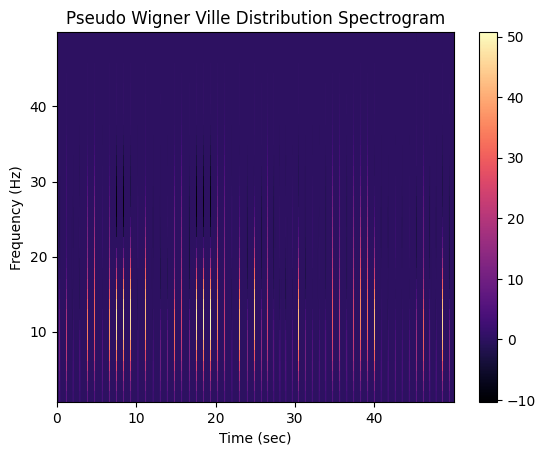

In [21]:
# from hrv import HRV 

# fs = 700

# ecg_ = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
# rpeaks = ecg_['rpeaks']
# # rpeaks = rpeaks / fs
# # hrv = nk.hrv_nonlinear(rpeaks, sampling_rate = 700)
# hrv_class = HRV(fs)
# HR = hrv_class.HR(rpeaks)

# filtered_ecg = ecg_['filtered']


# # print(HR)
# # STFT Method
# f, t, pwvd = nk.signal_timefrequency(filtered_ecg,
#                                      700,
#                                      max_frequency=50,
#                                      method="pwvd",
#                                      show=True)


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.patches import Ellipse
# import seaborn as sns

# # signal processing
# from scipy import signal
# from scipy.ndimage import label
# from scipy.stats import zscore
# from scipy.interpolate import interp1d
# from scipy.integrate import trapz

# # misc
# import warnings

In [ ]:
# x = np.cumsum(rpeaks) / 1000.0
# f = interp1d(x, rpeaks, kind='cubic')
# fs = 700
# steps = 1 / fs

# # now we can sample from interpolation function
# xx = np.arange(1, np.max(x), steps)
# rr_interpolated = f(xx)
# fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)


In [ ]:
# f, t, pwvd = nk.signal_timefrequency(filtered_ecg,
#                                      700,
#                                      max_frequency=50,
#                                      method="pwvd",
#                                      show=True)

In [5]:
# from scipy import signal
# import matplotlib.pyplot as plt
# import neurokit2 as nk
# import pyhrv.frequency_domain as fd
# import pyhrv.time_domain as td

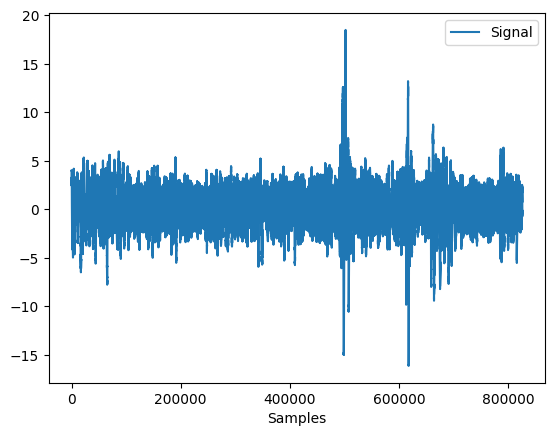

In [6]:
# nk.signal_plot(resp_base)

In [34]:
# ecg = ecg_base[10000: 10000+ fs * 50]
# resp =resp_base[10000: 10000+ fs * 50]

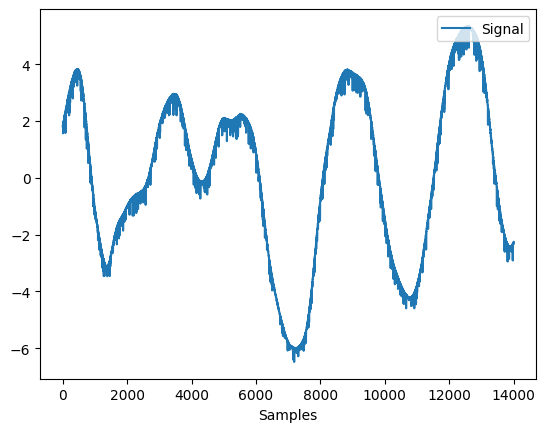

In [14]:
# nk.signal_plot(resp_base)

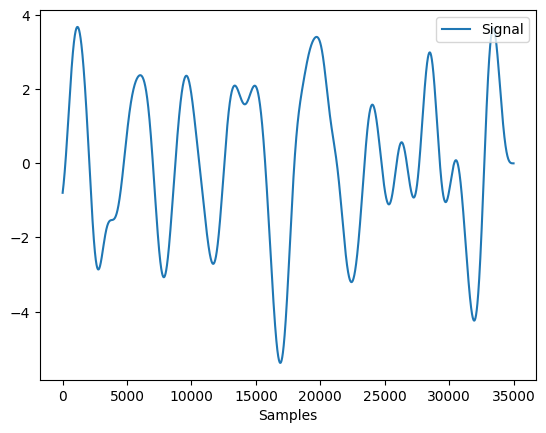

In [35]:
# ecg2 = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
# rpeaks = ecg2['rpeaks']
# # rpeaks = rpeaks / fs
# filtered_ecg = ecg2['filtered']
# # rpeaks, info = nk.ecg_peaks(ecg, sampling_rate=fs)
# ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(filtered_ecg))
# edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs)
# resp_peaks1, _ = signal.find_peaks(edr, height=0, distance=4)
# nk.signal_plot(edr)

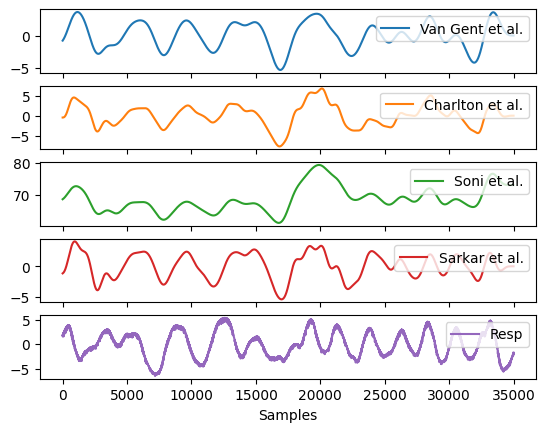

In [36]:
# edr_df = pd.DataFrame({
#     "Van Gent et al.": nk.ecg_rsp(ecg_rate, sampling_rate=fs),
#     "Charlton et al." : nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="charlton2016"),
#     "Soni et al.": nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="soni2019"),
#     "Sarkar et al.": nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="sarkar2015"),
#     "Resp": resp
#     })
# nk.signal_plot(edr_df, subplots=True)

In [61]:
# ecg = ecg_base[10000: 10000+ fs * 50]
# resp =resp_base[10000: 10000+ fs * 50]

# fs = 700
# ecg2 = td.ecg(ecg, interactive= False, show = False, sampling_rate=fs)
# rpeaks = ecg2['rpeaks']
# filtered_ecg = ecg2['filtered']
# ecg_rate = nk.ecg_rate(rpeaks, sampling_rate=fs, desired_length=len(filtered_ecg))
# edr = nk.ecg_rsp(ecg_rate, sampling_rate=fs, method="charlton2016")
# resp_peaks1, _ = signal.find_peaks(edr)


# rsp_rate = nk.signal_rate(peaks=resp_peaks1, sampling_rate = 700)

# print(max(rsp_rate), min(rsp_rate), np.std(rsp_rate), np.mean(rsp_rate))


{'RSP_Peaks': array([ 6343,  9709, 13066, 20120, 28560, 33393], dtype=int64), 'RSP_Troughs': array([ 2694,  7830, 11650, 16845, 22573, 32222], dtype=int64), 'sampling_rate': 700}
50.23923444976076 9.051724137931034 11.157643507816536 20.515884061546327


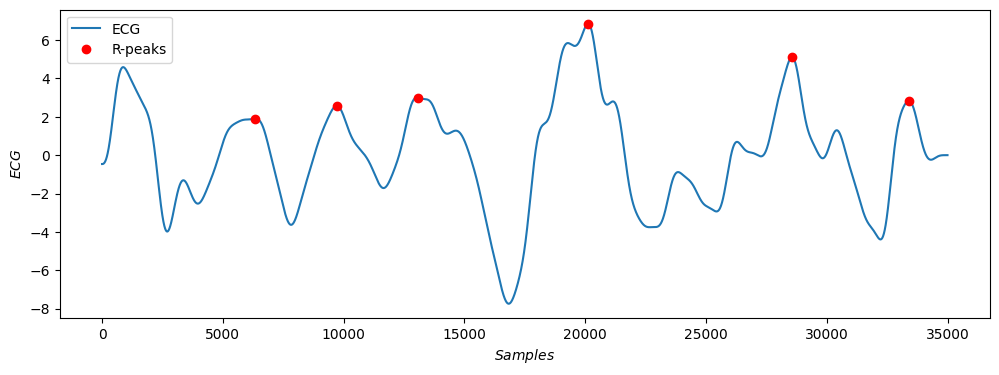

In [62]:
# plt.figure(figsize=(12,4))
# plt.plot(edr,label="ECG")
# plt.plot(info['RSP_Peaks'],edr[info['RSP_Peaks']], 'ro', label="R-peaks")
# plt.xlabel('$Samples$') 
# plt.ylabel('$ECG$') 
# plt.legend(loc='upper left')